# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 400, 400, 400, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=400, bias=True)
    (2): Tanh()
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): Tanh()
    (5): Linear(in_features=400, out_features=400, bias=True)
    (6): Tanh()
    (7): Linear(in_features=400, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 400, 400, 400, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1279
Epoch 1/200, Iteration 2/25, Loss: 2.5022
Epoch 1/200, Iteration 3/25, Loss: 6.9739
Epoch 1/200, Iteration 4/25, Loss: 4.7967
Epoch 1/200, Iteration 5/25, Loss: 1.6618
Epoch 1/200, Iteration 6/25, Loss: 1.7378
Epoch 1/200, Iteration 7/25, Loss: 3.2150
Epoch 1/200, Iteration 8/25, Loss: 3.6753
Epoch 1/200, Iteration 9/25, Loss: 2.9275
Epoch 1/200, Iteration 10/25, Loss: 1.8719
Epoch 1/200, Iteration 11/25, Loss: 0.2753
Epoch 1/200, Iteration 12/25, Loss: 1.6176
Epoch 1/200, Iteration 13/25, Loss: 2.7187
Epoch 1/200, Iteration 14/25, Loss: 3.0433
Epoch 1/200, Iteration 15/25, Loss: 3.1496
Epoch 1/200, Iteration 16/25, Loss: 2.4083
Epoch 1/200, Iteration 17/25, Loss: 1.2797
Epoch 1/200, Iteration 18/25, Loss: 0.2859
Epoch 1/200, Iteration 19/25, Loss: 1.4334
Epoch 1/200, Iteration 20/25, Loss: 2.1178
Epoch 1/200, Iteration 21/25, Loss: 2.1973
Epoch 1/200, Iteration 22/25, Loss: 1.8338
Epoch 1/200, Iteration 23/25, Loss: 1.0706
Epoch 1/200, Iterati

Epoch 7/200, Iteration 25/25, Loss: 0.1940
Train Error: 
 Accuracy: 13.0%, Avg loss: 0.200919, MRE: 11.950926 

Test Error: 
 Accuracy: 13.0%, Avg loss: 0.213723, MRE: 13.767739 

Epoch 8/200, Iteration 1/25, Loss: 0.1892
Epoch 8/200, Iteration 2/25, Loss: 0.1466
Epoch 8/200, Iteration 3/25, Loss: 0.0916
Epoch 8/200, Iteration 4/25, Loss: 0.2014
Epoch 8/200, Iteration 5/25, Loss: 0.2384
Epoch 8/200, Iteration 6/25, Loss: 0.2592
Epoch 8/200, Iteration 7/25, Loss: 0.1686
Epoch 8/200, Iteration 8/25, Loss: 0.2800
Epoch 8/200, Iteration 9/25, Loss: 0.3029
Epoch 8/200, Iteration 10/25, Loss: 0.2085
Epoch 8/200, Iteration 11/25, Loss: 0.3234
Epoch 8/200, Iteration 12/25, Loss: 0.1524
Epoch 8/200, Iteration 13/25, Loss: 0.2413
Epoch 8/200, Iteration 14/25, Loss: 0.1403
Epoch 8/200, Iteration 15/25, Loss: 0.4131
Epoch 8/200, Iteration 16/25, Loss: 0.3851
Epoch 8/200, Iteration 17/25, Loss: 0.2994
Epoch 8/200, Iteration 18/25, Loss: 0.2953
Epoch 8/200, Iteration 19/25, Loss: 0.2918
Epoch 8/200,

Train Error: 
 Accuracy: 80.88%, Avg loss: 0.089085, MRE: 8.491886 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.088544, MRE: 21.828743 

Epoch 15/200, Iteration 1/25, Loss: 0.1185
Epoch 15/200, Iteration 2/25, Loss: 0.1699
Epoch 15/200, Iteration 3/25, Loss: 0.2709
Epoch 15/200, Iteration 4/25, Loss: 0.1026
Epoch 15/200, Iteration 5/25, Loss: 0.1671
Epoch 15/200, Iteration 6/25, Loss: 0.2427
Epoch 15/200, Iteration 7/25, Loss: 0.1066
Epoch 15/200, Iteration 8/25, Loss: 0.1170
Epoch 15/200, Iteration 9/25, Loss: 0.1296
Epoch 15/200, Iteration 10/25, Loss: 0.0972
Epoch 15/200, Iteration 11/25, Loss: 0.1959
Epoch 15/200, Iteration 12/25, Loss: 0.3046
Epoch 15/200, Iteration 13/25, Loss: 0.1338
Epoch 15/200, Iteration 14/25, Loss: 0.2003
Epoch 15/200, Iteration 15/25, Loss: 0.1756
Epoch 15/200, Iteration 16/25, Loss: 0.1868
Epoch 15/200, Iteration 17/25, Loss: 0.2417
Epoch 15/200, Iteration 18/25, Loss: 0.1455
Epoch 15/200, Iteration 19/25, Loss: 0.1488
Epoch 15/200, Iteration 20/25, Loss:

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.438320, MRE: 28.596183 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.426182, MRE: 61.710629 

Epoch 22/200, Iteration 1/25, Loss: 0.4530
Epoch 22/200, Iteration 2/25, Loss: 0.4681
Epoch 22/200, Iteration 3/25, Loss: 0.3178
Epoch 22/200, Iteration 4/25, Loss: 0.2813
Epoch 22/200, Iteration 5/25, Loss: 0.1866
Epoch 22/200, Iteration 6/25, Loss: 0.2262
Epoch 22/200, Iteration 7/25, Loss: 0.2108
Epoch 22/200, Iteration 8/25, Loss: 0.1862
Epoch 22/200, Iteration 9/25, Loss: 0.2868
Epoch 22/200, Iteration 10/25, Loss: 0.1873
Epoch 22/200, Iteration 11/25, Loss: 0.2649
Epoch 22/200, Iteration 12/25, Loss: 0.4302
Epoch 22/200, Iteration 13/25, Loss: 0.3381
Epoch 22/200, Iteration 14/25, Loss: 0.2000
Epoch 22/200, Iteration 15/25, Loss: 0.2494
Epoch 22/200, Iteration 16/25, Loss: 0.3396
Epoch 22/200, Iteration 17/25, Loss: 0.1526
Epoch 22/200, Iteration 18/25, Loss: 0.2907
Epoch 22/200, Iteration 19/25, Loss: 0.3528
Epoch 22/200, Iteration 20/25, Los

Epoch 29/200, Iteration 1/25, Loss: 0.0741
Epoch 29/200, Iteration 2/25, Loss: 0.0807
Epoch 29/200, Iteration 3/25, Loss: 0.0955
Epoch 29/200, Iteration 4/25, Loss: 0.0835
Epoch 29/200, Iteration 5/25, Loss: 0.1140
Epoch 29/200, Iteration 6/25, Loss: 0.1232
Epoch 29/200, Iteration 7/25, Loss: 0.0896
Epoch 29/200, Iteration 8/25, Loss: 0.0821
Epoch 29/200, Iteration 9/25, Loss: 0.1037
Epoch 29/200, Iteration 10/25, Loss: 0.1453
Epoch 29/200, Iteration 11/25, Loss: 0.1278
Epoch 29/200, Iteration 12/25, Loss: 0.1514
Epoch 29/200, Iteration 13/25, Loss: 0.1699
Epoch 29/200, Iteration 14/25, Loss: 0.1973
Epoch 29/200, Iteration 15/25, Loss: 0.1091
Epoch 29/200, Iteration 16/25, Loss: 0.1423
Epoch 29/200, Iteration 17/25, Loss: 0.0856
Epoch 29/200, Iteration 18/25, Loss: 0.1524
Epoch 29/200, Iteration 19/25, Loss: 0.1694
Epoch 29/200, Iteration 20/25, Loss: 0.1564
Epoch 29/200, Iteration 21/25, Loss: 0.1601
Epoch 29/200, Iteration 22/25, Loss: 0.0693
Epoch 29/200, Iteration 23/25, Loss: 0.23

Train Error: 
 Accuracy: 55.75%, Avg loss: 0.171094, MRE: 10.804864 

Test Error: 
 Accuracy: 55.5%, Avg loss: 0.176113, MRE: 25.476286 

Epoch 36/200, Iteration 1/25, Loss: 0.1887
Epoch 36/200, Iteration 2/25, Loss: 0.0743
Epoch 36/200, Iteration 3/25, Loss: 0.2425
Epoch 36/200, Iteration 4/25, Loss: 0.1844
Epoch 36/200, Iteration 5/25, Loss: 0.2206
Epoch 36/200, Iteration 6/25, Loss: 0.3184
Epoch 36/200, Iteration 7/25, Loss: 0.1223
Epoch 36/200, Iteration 8/25, Loss: 0.3059
Epoch 36/200, Iteration 9/25, Loss: 0.4180
Epoch 36/200, Iteration 10/25, Loss: 0.1902
Epoch 36/200, Iteration 11/25, Loss: 0.3831
Epoch 36/200, Iteration 12/25, Loss: 0.4559
Epoch 36/200, Iteration 13/25, Loss: 0.2238
Epoch 36/200, Iteration 14/25, Loss: 0.2787
Epoch 36/200, Iteration 15/25, Loss: 0.3934
Epoch 36/200, Iteration 16/25, Loss: 0.2587
Epoch 36/200, Iteration 17/25, Loss: 0.1100
Epoch 36/200, Iteration 18/25, Loss: 0.2176
Epoch 36/200, Iteration 19/25, Loss: 0.1616
Epoch 36/200, Iteration 20/25, Loss

Epoch 43/200, Iteration 2/25, Loss: 0.0266
Epoch 43/200, Iteration 3/25, Loss: 0.0252
Epoch 43/200, Iteration 4/25, Loss: 0.0306
Epoch 43/200, Iteration 5/25, Loss: 0.0274
Epoch 43/200, Iteration 6/25, Loss: 0.0372
Epoch 43/200, Iteration 7/25, Loss: 0.0249
Epoch 43/200, Iteration 8/25, Loss: 0.0267
Epoch 43/200, Iteration 9/25, Loss: 0.0308
Epoch 43/200, Iteration 10/25, Loss: 0.0216
Epoch 43/200, Iteration 11/25, Loss: 0.0234
Epoch 43/200, Iteration 12/25, Loss: 0.0200
Epoch 43/200, Iteration 13/25, Loss: 0.0239
Epoch 43/200, Iteration 14/25, Loss: 0.0356
Epoch 43/200, Iteration 15/25, Loss: 0.0299
Epoch 43/200, Iteration 16/25, Loss: 0.0380
Epoch 43/200, Iteration 17/25, Loss: 0.0445
Epoch 43/200, Iteration 18/25, Loss: 0.0166
Epoch 43/200, Iteration 19/25, Loss: 0.0356
Epoch 43/200, Iteration 20/25, Loss: 0.0336
Epoch 43/200, Iteration 21/25, Loss: 0.0314
Epoch 43/200, Iteration 22/25, Loss: 0.0274
Epoch 43/200, Iteration 23/25, Loss: 0.0409
Epoch 43/200, Iteration 24/25, Loss: 0.0

Epoch 50/200, Iteration 5/25, Loss: 0.0229
Epoch 50/200, Iteration 6/25, Loss: 0.0171
Epoch 50/200, Iteration 7/25, Loss: 0.0321
Epoch 50/200, Iteration 8/25, Loss: 0.0218
Epoch 50/200, Iteration 9/25, Loss: 0.0200
Epoch 50/200, Iteration 10/25, Loss: 0.0386
Epoch 50/200, Iteration 11/25, Loss: 0.0261
Epoch 50/200, Iteration 12/25, Loss: 0.0223
Epoch 50/200, Iteration 13/25, Loss: 0.0206
Epoch 50/200, Iteration 14/25, Loss: 0.0282
Epoch 50/200, Iteration 15/25, Loss: 0.0429
Epoch 50/200, Iteration 16/25, Loss: 0.0357
Epoch 50/200, Iteration 17/25, Loss: 0.0243
Epoch 50/200, Iteration 18/25, Loss: 0.0276
Epoch 50/200, Iteration 19/25, Loss: 0.0250
Epoch 50/200, Iteration 20/25, Loss: 0.0342
Epoch 50/200, Iteration 21/25, Loss: 0.0279
Epoch 50/200, Iteration 22/25, Loss: 0.0177
Epoch 50/200, Iteration 23/25, Loss: 0.0262
Epoch 50/200, Iteration 24/25, Loss: 0.0385
Epoch 50/200, Iteration 25/25, Loss: 0.0320
Train Error: 
 Accuracy: 43.62%, Avg loss: 0.028835, MRE: 1.992270 

Test Error: 

Train Error: 
 Accuracy: 88.0%, Avg loss: 0.029603, MRE: 1.303438 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.033325, MRE: 6.314318 

Epoch 57/200, Iteration 1/25, Loss: 0.0200
Epoch 57/200, Iteration 2/25, Loss: 0.0282
Epoch 57/200, Iteration 3/25, Loss: 0.0366
Epoch 57/200, Iteration 4/25, Loss: 0.0254
Epoch 57/200, Iteration 5/25, Loss: 0.0212
Epoch 57/200, Iteration 6/25, Loss: 0.0304
Epoch 57/200, Iteration 7/25, Loss: 0.0137
Epoch 57/200, Iteration 8/25, Loss: 0.0222
Epoch 57/200, Iteration 9/25, Loss: 0.0335
Epoch 57/200, Iteration 10/25, Loss: 0.0324
Epoch 57/200, Iteration 11/25, Loss: 0.0267
Epoch 57/200, Iteration 12/25, Loss: 0.0230
Epoch 57/200, Iteration 13/25, Loss: 0.0304
Epoch 57/200, Iteration 14/25, Loss: 0.0208
Epoch 57/200, Iteration 15/25, Loss: 0.0261
Epoch 57/200, Iteration 16/25, Loss: 0.0336
Epoch 57/200, Iteration 17/25, Loss: 0.0270
Epoch 57/200, Iteration 18/25, Loss: 0.0391
Epoch 57/200, Iteration 19/25, Loss: 0.0333
Epoch 57/200, Iteration 20/25, Loss: 0

Epoch 63/200, Iteration 20/25, Loss: 0.0176
Epoch 63/200, Iteration 21/25, Loss: 0.0243
Epoch 63/200, Iteration 22/25, Loss: 0.0182
Epoch 63/200, Iteration 23/25, Loss: 0.0225
Epoch 63/200, Iteration 24/25, Loss: 0.0443
Epoch 63/200, Iteration 25/25, Loss: 0.0279
Train Error: 
 Accuracy: 63.75%, Avg loss: 0.018963, MRE: 1.146587 

Test Error: 
 Accuracy: 60.0%, Avg loss: 0.020285, MRE: 6.414420 

Epoch 64/200, Iteration 1/25, Loss: 0.0225
Epoch 64/200, Iteration 2/25, Loss: 0.0187
Epoch 64/200, Iteration 3/25, Loss: 0.0297
Epoch 64/200, Iteration 4/25, Loss: 0.0230
Epoch 64/200, Iteration 5/25, Loss: 0.0227
Epoch 64/200, Iteration 6/25, Loss: 0.0175
Epoch 64/200, Iteration 7/25, Loss: 0.0194
Epoch 64/200, Iteration 8/25, Loss: 0.0369
Epoch 64/200, Iteration 9/25, Loss: 0.0331
Epoch 64/200, Iteration 10/25, Loss: 0.0447
Epoch 64/200, Iteration 11/25, Loss: 0.0263
Epoch 64/200, Iteration 12/25, Loss: 0.0383
Epoch 64/200, Iteration 13/25, Loss: 0.0276
Epoch 64/200, Iteration 14/25, Loss: 

Train Error: 
 Accuracy: 91.88%, Avg loss: 0.011922, MRE: 0.701041 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.013943, MRE: 4.151251 

Epoch 71/200, Iteration 1/25, Loss: 0.0155
Epoch 71/200, Iteration 2/25, Loss: 0.0164
Epoch 71/200, Iteration 3/25, Loss: 0.0190
Epoch 71/200, Iteration 4/25, Loss: 0.0134
Epoch 71/200, Iteration 5/25, Loss: 0.0121
Epoch 71/200, Iteration 6/25, Loss: 0.0125
Epoch 71/200, Iteration 7/25, Loss: 0.0146
Epoch 71/200, Iteration 8/25, Loss: 0.0195
Epoch 71/200, Iteration 9/25, Loss: 0.0113
Epoch 71/200, Iteration 10/25, Loss: 0.0108
Epoch 71/200, Iteration 11/25, Loss: 0.0332
Epoch 71/200, Iteration 12/25, Loss: 0.0173
Epoch 71/200, Iteration 13/25, Loss: 0.0183
Epoch 71/200, Iteration 14/25, Loss: 0.0112
Epoch 71/200, Iteration 15/25, Loss: 0.0262
Epoch 71/200, Iteration 16/25, Loss: 0.0139
Epoch 71/200, Iteration 17/25, Loss: 0.0330
Epoch 71/200, Iteration 18/25, Loss: 0.0110
Epoch 71/200, Iteration 19/25, Loss: 0.0136
Epoch 71/200, Iteration 20/25, Loss: 

Epoch 77/200, Iteration 21/25, Loss: 0.0126
Epoch 77/200, Iteration 22/25, Loss: 0.0193
Epoch 77/200, Iteration 23/25, Loss: 0.0162
Epoch 77/200, Iteration 24/25, Loss: 0.0151
Epoch 77/200, Iteration 25/25, Loss: 0.0168
Train Error: 
 Accuracy: 66.12%, Avg loss: 0.010112, MRE: 0.863099 

Test Error: 
 Accuracy: 63.0%, Avg loss: 0.011645, MRE: 2.148312 

Epoch 78/200, Iteration 1/25, Loss: 0.0132
Epoch 78/200, Iteration 2/25, Loss: 0.0252
Epoch 78/200, Iteration 3/25, Loss: 0.0259
Epoch 78/200, Iteration 4/25, Loss: 0.0133
Epoch 78/200, Iteration 5/25, Loss: 0.0133
Epoch 78/200, Iteration 6/25, Loss: 0.0128
Epoch 78/200, Iteration 7/25, Loss: 0.0227
Epoch 78/200, Iteration 8/25, Loss: 0.0107
Epoch 78/200, Iteration 9/25, Loss: 0.0125
Epoch 78/200, Iteration 10/25, Loss: 0.0211
Epoch 78/200, Iteration 11/25, Loss: 0.0114
Epoch 78/200, Iteration 12/25, Loss: 0.0245
Epoch 78/200, Iteration 13/25, Loss: 0.0172
Epoch 78/200, Iteration 14/25, Loss: 0.0180
Epoch 78/200, Iteration 15/25, Loss: 

Epoch 84/200, Iteration 23/25, Loss: 0.0264
Epoch 84/200, Iteration 24/25, Loss: 0.0260
Epoch 84/200, Iteration 25/25, Loss: 0.0156
Train Error: 
 Accuracy: 86.25%, Avg loss: 0.010538, MRE: 0.604832 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.012739, MRE: 1.894123 

Epoch 85/200, Iteration 1/25, Loss: 0.0153
Epoch 85/200, Iteration 2/25, Loss: 0.0159
Epoch 85/200, Iteration 3/25, Loss: 0.0202
Epoch 85/200, Iteration 4/25, Loss: 0.0120
Epoch 85/200, Iteration 5/25, Loss: 0.0161
Epoch 85/200, Iteration 6/25, Loss: 0.0112
Epoch 85/200, Iteration 7/25, Loss: 0.0265
Epoch 85/200, Iteration 8/25, Loss: 0.0142
Epoch 85/200, Iteration 9/25, Loss: 0.0132
Epoch 85/200, Iteration 10/25, Loss: 0.0255
Epoch 85/200, Iteration 11/25, Loss: 0.0317
Epoch 85/200, Iteration 12/25, Loss: 0.0157
Epoch 85/200, Iteration 13/25, Loss: 0.0198
Epoch 85/200, Iteration 14/25, Loss: 0.0131
Epoch 85/200, Iteration 15/25, Loss: 0.0253
Epoch 85/200, Iteration 16/25, Loss: 0.0183
Epoch 85/200, Iteration 17/25, Loss: 

Train Error: 
 Accuracy: 75.0%, Avg loss: 0.009081, MRE: 0.653076 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.010840, MRE: 2.175481 

Epoch 92/200, Iteration 1/25, Loss: 0.0212
Epoch 92/200, Iteration 2/25, Loss: 0.0144
Epoch 92/200, Iteration 3/25, Loss: 0.0160
Epoch 92/200, Iteration 4/25, Loss: 0.0119
Epoch 92/200, Iteration 5/25, Loss: 0.0217
Epoch 92/200, Iteration 6/25, Loss: 0.0130
Epoch 92/200, Iteration 7/25, Loss: 0.0143
Epoch 92/200, Iteration 8/25, Loss: 0.0140
Epoch 92/200, Iteration 9/25, Loss: 0.0148
Epoch 92/200, Iteration 10/25, Loss: 0.0148
Epoch 92/200, Iteration 11/25, Loss: 0.0196
Epoch 92/200, Iteration 12/25, Loss: 0.0167
Epoch 92/200, Iteration 13/25, Loss: 0.0141
Epoch 92/200, Iteration 14/25, Loss: 0.0136
Epoch 92/200, Iteration 15/25, Loss: 0.0233
Epoch 92/200, Iteration 16/25, Loss: 0.0212
Epoch 92/200, Iteration 17/25, Loss: 0.0118
Epoch 92/200, Iteration 18/25, Loss: 0.0265
Epoch 92/200, Iteration 19/25, Loss: 0.0094
Epoch 92/200, Iteration 20/25, Loss: 0

Epoch 98/200, Iteration 20/25, Loss: 0.0099
Epoch 98/200, Iteration 21/25, Loss: 0.0169
Epoch 98/200, Iteration 22/25, Loss: 0.0099
Epoch 98/200, Iteration 23/25, Loss: 0.0259
Epoch 98/200, Iteration 24/25, Loss: 0.0104
Epoch 98/200, Iteration 25/25, Loss: 0.0139
Train Error: 
 Accuracy: 82.75%, Avg loss: 0.010246, MRE: 0.740997 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.012060, MRE: 1.399959 

Epoch 99/200, Iteration 1/25, Loss: 0.0128
Epoch 99/200, Iteration 2/25, Loss: 0.0231
Epoch 99/200, Iteration 3/25, Loss: 0.0090
Epoch 99/200, Iteration 4/25, Loss: 0.0130
Epoch 99/200, Iteration 5/25, Loss: 0.0237
Epoch 99/200, Iteration 6/25, Loss: 0.0178
Epoch 99/200, Iteration 7/25, Loss: 0.0188
Epoch 99/200, Iteration 8/25, Loss: 0.0121
Epoch 99/200, Iteration 9/25, Loss: 0.0155
Epoch 99/200, Iteration 10/25, Loss: 0.0136
Epoch 99/200, Iteration 11/25, Loss: 0.0106
Epoch 99/200, Iteration 12/25, Loss: 0.0091
Epoch 99/200, Iteration 13/25, Loss: 0.0214
Epoch 99/200, Iteration 14/25, Loss: 

Epoch 105/200, Iteration 25/25, Loss: 0.0195
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.009703, MRE: 0.655986 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.012077, MRE: 1.629963 

Epoch 106/200, Iteration 1/25, Loss: 0.0205
Epoch 106/200, Iteration 2/25, Loss: 0.0112
Epoch 106/200, Iteration 3/25, Loss: 0.0129
Epoch 106/200, Iteration 4/25, Loss: 0.0200
Epoch 106/200, Iteration 5/25, Loss: 0.0114
Epoch 106/200, Iteration 6/25, Loss: 0.0072
Epoch 106/200, Iteration 7/25, Loss: 0.0189
Epoch 106/200, Iteration 8/25, Loss: 0.0112
Epoch 106/200, Iteration 9/25, Loss: 0.0152
Epoch 106/200, Iteration 10/25, Loss: 0.0128
Epoch 106/200, Iteration 11/25, Loss: 0.0259
Epoch 106/200, Iteration 12/25, Loss: 0.0218
Epoch 106/200, Iteration 13/25, Loss: 0.0129
Epoch 106/200, Iteration 14/25, Loss: 0.0123
Epoch 106/200, Iteration 15/25, Loss: 0.0170
Epoch 106/200, Iteration 16/25, Loss: 0.0296
Epoch 106/200, Iteration 17/25, Loss: 0.0121
Epoch 106/200, Iteration 18/25, Loss: 0.0138
Epoch 106/200, Ite

Train Error: 
 Accuracy: 93.62%, Avg loss: 0.008319, MRE: 0.487109 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.009963, MRE: 1.968633 

Epoch 113/200, Iteration 1/25, Loss: 0.0096
Epoch 113/200, Iteration 2/25, Loss: 0.0154
Epoch 113/200, Iteration 3/25, Loss: 0.0074
Epoch 113/200, Iteration 4/25, Loss: 0.0084
Epoch 113/200, Iteration 5/25, Loss: 0.0206
Epoch 113/200, Iteration 6/25, Loss: 0.0178
Epoch 113/200, Iteration 7/25, Loss: 0.0107
Epoch 113/200, Iteration 8/25, Loss: 0.0129
Epoch 113/200, Iteration 9/25, Loss: 0.0144
Epoch 113/200, Iteration 10/25, Loss: 0.0166
Epoch 113/200, Iteration 11/25, Loss: 0.0083
Epoch 113/200, Iteration 12/25, Loss: 0.0242
Epoch 113/200, Iteration 13/25, Loss: 0.0112
Epoch 113/200, Iteration 14/25, Loss: 0.0115
Epoch 113/200, Iteration 15/25, Loss: 0.0138
Epoch 113/200, Iteration 16/25, Loss: 0.0398
Epoch 113/200, Iteration 17/25, Loss: 0.0299
Epoch 113/200, Iteration 18/25, Loss: 0.0120
Epoch 113/200, Iteration 19/25, Loss: 0.0250
Epoch 113/200, Ite

Epoch 119/200, Iteration 18/25, Loss: 0.0212
Epoch 119/200, Iteration 19/25, Loss: 0.0069
Epoch 119/200, Iteration 20/25, Loss: 0.0134
Epoch 119/200, Iteration 21/25, Loss: 0.0120
Epoch 119/200, Iteration 22/25, Loss: 0.0262
Epoch 119/200, Iteration 23/25, Loss: 0.0090
Epoch 119/200, Iteration 24/25, Loss: 0.0255
Epoch 119/200, Iteration 25/25, Loss: 0.0195
Train Error: 
 Accuracy: 80.75%, Avg loss: 0.007637, MRE: 0.624001 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.010027, MRE: 1.641135 

Epoch 120/200, Iteration 1/25, Loss: 0.0100
Epoch 120/200, Iteration 2/25, Loss: 0.0190
Epoch 120/200, Iteration 3/25, Loss: 0.0157
Epoch 120/200, Iteration 4/25, Loss: 0.0087
Epoch 120/200, Iteration 5/25, Loss: 0.0393
Epoch 120/200, Iteration 6/25, Loss: 0.0111
Epoch 120/200, Iteration 7/25, Loss: 0.0312
Epoch 120/200, Iteration 8/25, Loss: 0.0107
Epoch 120/200, Iteration 9/25, Loss: 0.0098
Epoch 120/200, Iteration 10/25, Loss: 0.0113
Epoch 120/200, Iteration 11/25, Loss: 0.0105
Epoch 120/200, Ite

Epoch 126/200, Iteration 19/25, Loss: 0.0102
Epoch 126/200, Iteration 20/25, Loss: 0.0069
Epoch 126/200, Iteration 21/25, Loss: 0.0184
Epoch 126/200, Iteration 22/25, Loss: 0.0306
Epoch 126/200, Iteration 23/25, Loss: 0.0411
Epoch 126/200, Iteration 24/25, Loss: 0.0225
Epoch 126/200, Iteration 25/25, Loss: 0.0107
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.009259, MRE: 0.588120 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.011491, MRE: 2.055533 

Epoch 127/200, Iteration 1/25, Loss: 0.0106
Epoch 127/200, Iteration 2/25, Loss: 0.0118
Epoch 127/200, Iteration 3/25, Loss: 0.0116
Epoch 127/200, Iteration 4/25, Loss: 0.0158
Epoch 127/200, Iteration 5/25, Loss: 0.0234
Epoch 127/200, Iteration 6/25, Loss: 0.0181
Epoch 127/200, Iteration 7/25, Loss: 0.0093
Epoch 127/200, Iteration 8/25, Loss: 0.0076
Epoch 127/200, Iteration 9/25, Loss: 0.0132
Epoch 127/200, Iteration 10/25, Loss: 0.0139
Epoch 127/200, Iteration 11/25, Loss: 0.0230
Epoch 127/200, Iteration 12/25, Loss: 0.0093
Epoch 127/200, Ite

Epoch 133/200, Iteration 14/25, Loss: 0.0108
Epoch 133/200, Iteration 15/25, Loss: 0.0276
Epoch 133/200, Iteration 16/25, Loss: 0.0318
Epoch 133/200, Iteration 17/25, Loss: 0.0201
Epoch 133/200, Iteration 18/25, Loss: 0.0125
Epoch 133/200, Iteration 19/25, Loss: 0.0125
Epoch 133/200, Iteration 20/25, Loss: 0.0231
Epoch 133/200, Iteration 21/25, Loss: 0.0102
Epoch 133/200, Iteration 22/25, Loss: 0.0145
Epoch 133/200, Iteration 23/25, Loss: 0.0227
Epoch 133/200, Iteration 24/25, Loss: 0.0163
Epoch 133/200, Iteration 25/25, Loss: 0.0090
Train Error: 
 Accuracy: 83.12%, Avg loss: 0.007503, MRE: 0.593126 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.010127, MRE: 1.613403 

Epoch 134/200, Iteration 1/25, Loss: 0.0112
Epoch 134/200, Iteration 2/25, Loss: 0.0181
Epoch 134/200, Iteration 3/25, Loss: 0.0111
Epoch 134/200, Iteration 4/25, Loss: 0.0077
Epoch 134/200, Iteration 5/25, Loss: 0.0107
Epoch 134/200, Iteration 6/25, Loss: 0.0104
Epoch 134/200, Iteration 7/25, Loss: 0.0218
Epoch 134/200, I

Epoch 140/200, Iteration 18/25, Loss: 0.0105
Epoch 140/200, Iteration 19/25, Loss: 0.0103
Epoch 140/200, Iteration 20/25, Loss: 0.0098
Epoch 140/200, Iteration 21/25, Loss: 0.0099
Epoch 140/200, Iteration 22/25, Loss: 0.0102
Epoch 140/200, Iteration 23/25, Loss: 0.0127
Epoch 140/200, Iteration 24/25, Loss: 0.0157
Epoch 140/200, Iteration 25/25, Loss: 0.0137
Train Error: 
 Accuracy: 85.75%, Avg loss: 0.007332, MRE: 0.586385 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.009714, MRE: 1.748996 

Epoch 141/200, Iteration 1/25, Loss: 0.0108
Epoch 141/200, Iteration 2/25, Loss: 0.0106
Epoch 141/200, Iteration 3/25, Loss: 0.0096
Epoch 141/200, Iteration 4/25, Loss: 0.0284
Epoch 141/200, Iteration 5/25, Loss: 0.0153
Epoch 141/200, Iteration 6/25, Loss: 0.0158
Epoch 141/200, Iteration 7/25, Loss: 0.0075
Epoch 141/200, Iteration 8/25, Loss: 0.0098
Epoch 141/200, Iteration 9/25, Loss: 0.0070
Epoch 141/200, Iteration 10/25, Loss: 0.0095
Epoch 141/200, Iteration 11/25, Loss: 0.0198
Epoch 141/200, Ite

Epoch 147/200, Iteration 21/25, Loss: 0.0094
Epoch 147/200, Iteration 22/25, Loss: 0.0150
Epoch 147/200, Iteration 23/25, Loss: 0.0197
Epoch 147/200, Iteration 24/25, Loss: 0.0106
Epoch 147/200, Iteration 25/25, Loss: 0.0095
Train Error: 
 Accuracy: 83.0%, Avg loss: 0.007270, MRE: 0.621140 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.009743, MRE: 1.938833 

Epoch 148/200, Iteration 1/25, Loss: 0.0096
Epoch 148/200, Iteration 2/25, Loss: 0.0103
Epoch 148/200, Iteration 3/25, Loss: 0.0060
Epoch 148/200, Iteration 4/25, Loss: 0.0274
Epoch 148/200, Iteration 5/25, Loss: 0.0101
Epoch 148/200, Iteration 6/25, Loss: 0.0099
Epoch 148/200, Iteration 7/25, Loss: 0.0265
Epoch 148/200, Iteration 8/25, Loss: 0.0130
Epoch 148/200, Iteration 9/25, Loss: 0.0126
Epoch 148/200, Iteration 10/25, Loss: 0.0105
Epoch 148/200, Iteration 11/25, Loss: 0.0109
Epoch 148/200, Iteration 12/25, Loss: 0.0129
Epoch 148/200, Iteration 13/25, Loss: 0.0093
Epoch 148/200, Iteration 14/25, Loss: 0.0087
Epoch 148/200, Iter

Epoch 154/200, Iteration 9/25, Loss: 0.0329
Epoch 154/200, Iteration 10/25, Loss: 0.0086
Epoch 154/200, Iteration 11/25, Loss: 0.0116
Epoch 154/200, Iteration 12/25, Loss: 0.0345
Epoch 154/200, Iteration 13/25, Loss: 0.0098
Epoch 154/200, Iteration 14/25, Loss: 0.0219
Epoch 154/200, Iteration 15/25, Loss: 0.0262
Epoch 154/200, Iteration 16/25, Loss: 0.0160
Epoch 154/200, Iteration 17/25, Loss: 0.0083
Epoch 154/200, Iteration 18/25, Loss: 0.0128
Epoch 154/200, Iteration 19/25, Loss: 0.0093
Epoch 154/200, Iteration 20/25, Loss: 0.0092
Epoch 154/200, Iteration 21/25, Loss: 0.0136
Epoch 154/200, Iteration 22/25, Loss: 0.0139
Epoch 154/200, Iteration 23/25, Loss: 0.0169
Epoch 154/200, Iteration 24/25, Loss: 0.0208
Epoch 154/200, Iteration 25/25, Loss: 0.0103
Train Error: 
 Accuracy: 86.0%, Avg loss: 0.007126, MRE: 0.578958 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.009681, MRE: 1.736744 

Epoch 155/200, Iteration 1/25, Loss: 0.0088
Epoch 155/200, Iteration 2/25, Loss: 0.0131
Epoch 155/200

Train Error: 
 Accuracy: 79.0%, Avg loss: 0.007556, MRE: 0.545834 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.010138, MRE: 1.922858 

Epoch 161/200, Iteration 1/25, Loss: 0.0081
Epoch 161/200, Iteration 2/25, Loss: 0.0115
Epoch 161/200, Iteration 3/25, Loss: 0.0122
Epoch 161/200, Iteration 4/25, Loss: 0.0195
Epoch 161/200, Iteration 5/25, Loss: 0.0095
Epoch 161/200, Iteration 6/25, Loss: 0.0167
Epoch 161/200, Iteration 7/25, Loss: 0.0237
Epoch 161/200, Iteration 8/25, Loss: 0.0178
Epoch 161/200, Iteration 9/25, Loss: 0.0163
Epoch 161/200, Iteration 10/25, Loss: 0.0153
Epoch 161/200, Iteration 11/25, Loss: 0.0110
Epoch 161/200, Iteration 12/25, Loss: 0.0084
Epoch 161/200, Iteration 13/25, Loss: 0.0108
Epoch 161/200, Iteration 14/25, Loss: 0.0100
Epoch 161/200, Iteration 15/25, Loss: 0.0118
Epoch 161/200, Iteration 16/25, Loss: 0.0086
Epoch 161/200, Iteration 17/25, Loss: 0.0126
Epoch 161/200, Iteration 18/25, Loss: 0.0208
Epoch 161/200, Iteration 19/25, Loss: 0.0305
Epoch 161/200, Iter

Epoch 167/200, Iteration 22/25, Loss: 0.0297
Epoch 167/200, Iteration 23/25, Loss: 0.0095
Epoch 167/200, Iteration 24/25, Loss: 0.0103
Epoch 167/200, Iteration 25/25, Loss: 0.0283
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.007773, MRE: 0.559612 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.009555, MRE: 2.160945 

Epoch 168/200, Iteration 1/25, Loss: 0.0103
Epoch 168/200, Iteration 2/25, Loss: 0.0145
Epoch 168/200, Iteration 3/25, Loss: 0.0317
Epoch 168/200, Iteration 4/25, Loss: 0.0153
Epoch 168/200, Iteration 5/25, Loss: 0.0143
Epoch 168/200, Iteration 6/25, Loss: 0.0215
Epoch 168/200, Iteration 7/25, Loss: 0.0282
Epoch 168/200, Iteration 8/25, Loss: 0.0156
Epoch 168/200, Iteration 9/25, Loss: 0.0122
Epoch 168/200, Iteration 10/25, Loss: 0.0145
Epoch 168/200, Iteration 11/25, Loss: 0.0404
Epoch 168/200, Iteration 12/25, Loss: 0.0098
Epoch 168/200, Iteration 13/25, Loss: 0.0164
Epoch 168/200, Iteration 14/25, Loss: 0.0094
Epoch 168/200, Iteration 15/25, Loss: 0.0372
Epoch 168/200, Ite

Epoch 174/200, Iteration 14/25, Loss: 0.0084
Epoch 174/200, Iteration 15/25, Loss: 0.0237
Epoch 174/200, Iteration 16/25, Loss: 0.0145
Epoch 174/200, Iteration 17/25, Loss: 0.0073
Epoch 174/200, Iteration 18/25, Loss: 0.0112
Epoch 174/200, Iteration 19/25, Loss: 0.0075
Epoch 174/200, Iteration 20/25, Loss: 0.0163
Epoch 174/200, Iteration 21/25, Loss: 0.0153
Epoch 174/200, Iteration 22/25, Loss: 0.0162
Epoch 174/200, Iteration 23/25, Loss: 0.0161
Epoch 174/200, Iteration 24/25, Loss: 0.0077
Epoch 174/200, Iteration 25/25, Loss: 0.0124
Train Error: 
 Accuracy: 88.25%, Avg loss: 0.007128, MRE: 0.582126 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.009667, MRE: 1.688390 

Epoch 175/200, Iteration 1/25, Loss: 0.0088
Epoch 175/200, Iteration 2/25, Loss: 0.0120
Epoch 175/200, Iteration 3/25, Loss: 0.0123
Epoch 175/200, Iteration 4/25, Loss: 0.0105
Epoch 175/200, Iteration 5/25, Loss: 0.0159
Epoch 175/200, Iteration 6/25, Loss: 0.0137
Epoch 175/200, Iteration 7/25, Loss: 0.0164
Epoch 175/200, I

Epoch 181/200, Iteration 13/25, Loss: 0.0220
Epoch 181/200, Iteration 14/25, Loss: 0.0165
Epoch 181/200, Iteration 15/25, Loss: 0.0084
Epoch 181/200, Iteration 16/25, Loss: 0.0081
Epoch 181/200, Iteration 17/25, Loss: 0.0129
Epoch 181/200, Iteration 18/25, Loss: 0.0345
Epoch 181/200, Iteration 19/25, Loss: 0.0137
Epoch 181/200, Iteration 20/25, Loss: 0.0126
Epoch 181/200, Iteration 21/25, Loss: 0.0090
Epoch 181/200, Iteration 22/25, Loss: 0.0097
Epoch 181/200, Iteration 23/25, Loss: 0.0069
Epoch 181/200, Iteration 24/25, Loss: 0.0142
Epoch 181/200, Iteration 25/25, Loss: 0.0110
Train Error: 
 Accuracy: 89.5%, Avg loss: 0.007116, MRE: 0.500527 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.009619, MRE: 1.847632 

Epoch 182/200, Iteration 1/25, Loss: 0.0103
Epoch 182/200, Iteration 2/25, Loss: 0.0082
Epoch 182/200, Iteration 3/25, Loss: 0.0143
Epoch 182/200, Iteration 4/25, Loss: 0.0125
Epoch 182/200, Iteration 5/25, Loss: 0.0162
Epoch 182/200, Iteration 6/25, Loss: 0.0173
Epoch 182/200, I

Epoch 188/200, Iteration 17/25, Loss: 0.0223
Epoch 188/200, Iteration 18/25, Loss: 0.0132
Epoch 188/200, Iteration 19/25, Loss: 0.0224
Epoch 188/200, Iteration 20/25, Loss: 0.0102
Epoch 188/200, Iteration 21/25, Loss: 0.0141
Epoch 188/200, Iteration 22/25, Loss: 0.0098
Epoch 188/200, Iteration 23/25, Loss: 0.0122
Epoch 188/200, Iteration 24/25, Loss: 0.0084
Epoch 188/200, Iteration 25/25, Loss: 0.0110
Train Error: 
 Accuracy: 82.12%, Avg loss: 0.007248, MRE: 0.564345 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.010059, MRE: 1.668935 

Epoch 189/200, Iteration 1/25, Loss: 0.0084
Epoch 189/200, Iteration 2/25, Loss: 0.0095
Epoch 189/200, Iteration 3/25, Loss: 0.0143
Epoch 189/200, Iteration 4/25, Loss: 0.0168
Epoch 189/200, Iteration 5/25, Loss: 0.0149
Epoch 189/200, Iteration 6/25, Loss: 0.0117
Epoch 189/200, Iteration 7/25, Loss: 0.0118
Epoch 189/200, Iteration 8/25, Loss: 0.0131
Epoch 189/200, Iteration 9/25, Loss: 0.0090
Epoch 189/200, Iteration 10/25, Loss: 0.0156
Epoch 189/200, Ite

Epoch 195/200, Iteration 14/25, Loss: 0.0164
Epoch 195/200, Iteration 15/25, Loss: 0.0087
Epoch 195/200, Iteration 16/25, Loss: 0.0114
Epoch 195/200, Iteration 17/25, Loss: 0.0088
Epoch 195/200, Iteration 18/25, Loss: 0.0132
Epoch 195/200, Iteration 19/25, Loss: 0.0226
Epoch 195/200, Iteration 20/25, Loss: 0.0142
Epoch 195/200, Iteration 21/25, Loss: 0.0224
Epoch 195/200, Iteration 22/25, Loss: 0.0082
Epoch 195/200, Iteration 23/25, Loss: 0.0320
Epoch 195/200, Iteration 24/25, Loss: 0.0258
Epoch 195/200, Iteration 25/25, Loss: 0.0152
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.007207, MRE: 0.577627 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.009379, MRE: 1.875215 

Epoch 196/200, Iteration 1/25, Loss: 0.0163
Epoch 196/200, Iteration 2/25, Loss: 0.0199
Epoch 196/200, Iteration 3/25, Loss: 0.0166
Epoch 196/200, Iteration 4/25, Loss: 0.0178
Epoch 196/200, Iteration 5/25, Loss: 0.0072
Epoch 196/200, Iteration 6/25, Loss: 0.0364
Epoch 196/200, Iteration 7/25, Loss: 0.0126
Epoch 196/200, It

#### Plots loss vs Epoch

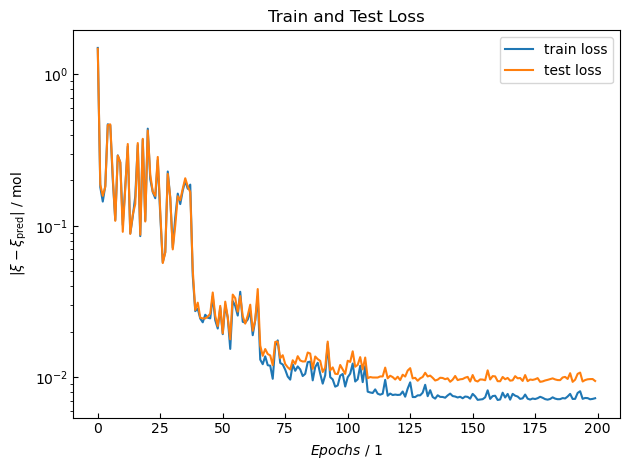

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9646006493106154
Test Dataset: R^2 = 0.9528025653582853


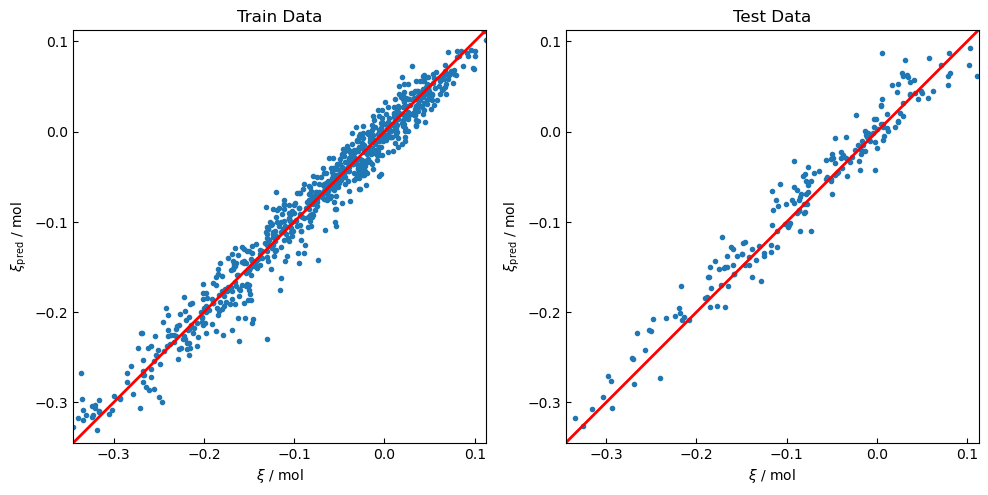

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())


print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))    

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

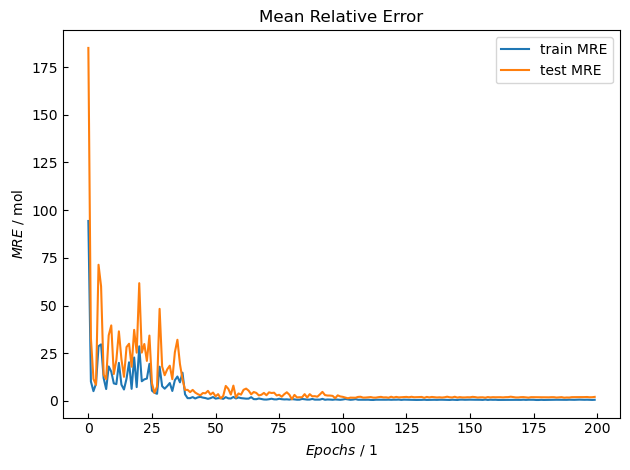

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

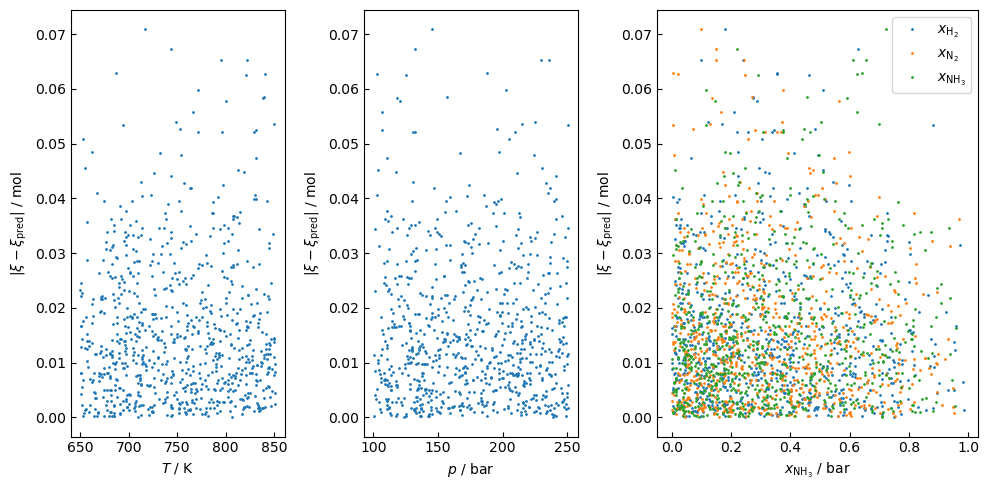

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

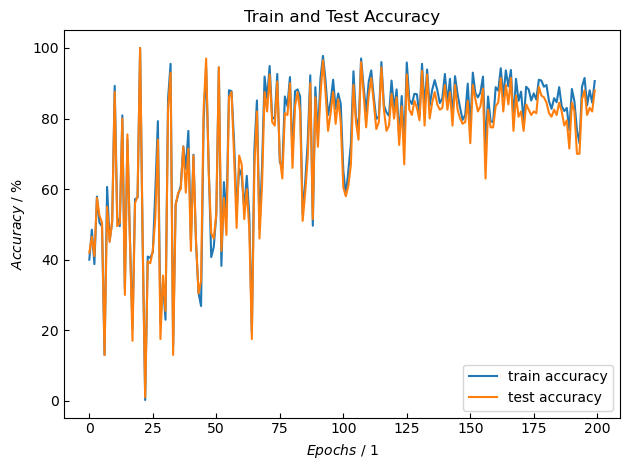

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.8401e+02, 1.7546e+02, 1.3719e-01, 5.1704e-01, 3.4577e-01],
        [8.3569e+02, 1.4553e+02, 5.5183e-01, 3.5300e-01, 9.5170e-02],
        [8.4121e+02, 1.3473e+02, 4.0342e-03, 9.5056e-01, 4.5407e-02],
        [7.7093e+02, 2.0515e+02, 2.4618e-01, 2.2027e-01, 5.3355e-01],
        [7.7845e+02, 1.8321e+02, 7.8849e-01, 1.7490e-01, 3.6606e-02],
        [8.2063e+02, 1.2521e+02, 4.6230e-01, 2.4657e-01, 2.9113e-01],
        [7.8598e+02, 2.4631e+02, 4.1589e-02, 3.9056e-01, 5.6785e-01],
        [7.0958e+02, 1.2331e+02, 7.4902e-01, 1.6056e-01, 9.0423e-02],
        [8.3265e+02, 1.1713e+02, 7.6982e-01, 7.0524e-02, 1.5965e-01],
        [7.7316e+02, 1.3285e+02, 3.8277e-01, 4.8648e-01, 1.3075e-01],
        [8.1887e+02, 1.1761e+02, 3.1445e-01, 1.7396e-01, 5.1159e-01],
        [6.9442e+02, 2.3650e+02, 1.4670e-01, 1.7898e-01, 6.7433e-01],
        [6.5312e+02, 2.0496e+02, 3.0368e-01, 2.5637e-01, 4.3995e-01],
        [6.9843e+02, 1.5427e+02, 5.0070e-01, 4.6900e-01, 3.0292e-02],
        [7.2460e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([1.0374, 1.0321, 1.0136, 1.0522, 1.0184], requires_grad=True),
 Parameter containing:
 tensor([ 0.1545,  0.1058, -0.0084, -0.1005,  0.0283], requires_grad=True),
 Parameter containing:
 tensor([[-0.4586,  0.2215, -0.0819,  0.4079, -0.1882],
         [ 0.0456, -0.1758,  0.5002, -0.0741, -0.2979],
         [-0.1038, -0.3446, -0.0779,  0.0277, -0.0834],
         ...,
         [ 0.3246, -0.1788,  0.0454, -0.5677,  0.3536],
         [ 0.1327,  0.3989, -0.2957, -0.2571, -0.0822],
         [-0.2800,  0.0121, -0.1989,  0.4738, -0.3143]], requires_grad=True),
 Parameter containing:
 tensor([ 3.5219e-01, -2.7366e-01, -4.9087e-02,  1.7131e-01,  2.7529e-01,
         -2.8292e-02, -1.4587e-01,  2.7330e-01, -3.0224e-01,  1.0391e-01,
         -3.1483e-01,  3.1428e-01, -1.8677e-01,  2.0386e-01, -2.3151e-01,
          5.5419e-01,  3.2413e-01, -1.6957e-01, -1.9898e-01, -1.3458e-01,
          3.3324e-01,  1.4634e-01, -2.3055e-01, -2.7264e-01,  2.9831e-01,
         -2.2098e-0

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2226, 0.6399, 0.9480, 0.4881, 0.4870],
        [0.3648, 0.8794, 0.6959, 0.5936, 0.9378]])
tensor([[ 0.0274],
        [-0.1649]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[7.6064e+02, 2.0704e+02, 4.0792e-02, 4.7369e-01, 4.8552e-01],
        [8.2292e+02, 1.5677e+02, 8.6543e-01, 1.2439e-01, 1.0177e-02],
        [7.5663e+02, 2.1536e+02, 8.8316e-01, 9.2420e-02, 2.4418e-02],
        [7.6859e+02, 1.1168e+02, 6.2213e-02, 2.6283e-01, 6.7495e-01],
        [6.9715e+02, 1.5958e+02, 5.7479e-01, 2.0517e-01, 2.2004e-01],
        [6.8633e+02, 2.1549e+02, 3.7100e-01, 4.0728e-01, 2.2172e-01],
        [7.4053e+02, 1.9513e+02, 4.4589e-01, 1.0410e-01, 4.5001e-01],
        [7.0290e+02, 1.5607e+02, 1.6307e-01, 2.8619e-01, 5.5074e-01],
        [6.9723e+02, 1.5600e+02, 2.8456e-01, 7.5954e-02, 6.3948e-01],
        [7.2992e+02, 1.7058e+02, 1.1824e-01, 4.8441e-01, 3.9735e-01],
        [7.3953e+02, 1.7389e+02, 8.2656e-02, 5.2258e-01, 3.9477e-01],
        [7.2717e+02, 1.7124e+02, 4.3540e-04, 3.3121e-01, 6.6835e-01],
        [7.2403e+02, 1.3865e+02, 7.2111e-02, 4.4622e-02, 8.8327e-01],
        [7.6141e+02, 1.5784e+02, 6.7901e-01, 1.5278e-01, 1.6821e-01],
        [6.9838e+02,